In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
from septum_mec.analysis.plotting import plot_psth, plot_waveforms
import expipe
import os
import pathlib
import numpy as np
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq

07:31:22 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

binsize = par['spat_binsize']
smoothing = 0.03
plt.rcParams['figure.figsize'] = (12,9)

In [4]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [28]:
def psth(sptr, stim_times, start_time, stop_time, binsize, axs=None):
    if axs is None:
        fig, axs = plt.subplots(2, 1, sharex=True)
    
    spike_times = sptr.magnitude
    trials = [spike_times[(spike_times > t + start_time) & (spike_times <= t + stop_time)] - t for t in stim_times]
    trials_ids = [[i]*len(t) for i, t in enumerate(trials)]

    trials_flat = [s for t in trials for s in t]
    trials_ids_flat = [s for t in trials_ids for s in t]

    axs[1].scatter(trials_flat, trials_ids_flat, s=1)
    bins = np.arange(start_time, stop_time + binsize, binsize)
    axs[0].hist(trials_flat, bins=bins);
    axs[0].set_title('channel group {} {}'.format(
        sptr.annotations['group_id'], sptr.annotations['name']))

In [6]:
action_id = "1833-050619-2"
channel_ids = range(8)
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = dp.get_data_path(action)
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

epochs = dp.load_epochs(data_path)

Project path: /media/storage/expipe/septum-mec
Data path: actions/1833-050619-2/data/main.exdir


In [7]:
print('stimulation periode', np.diff(epochs[0].times.magnitude).mean())
print('stimulation frequency', 1 / np.diff(epochs[0].times.magnitude).mean())

stimulation periode 0.09000341034103411
stimulation frequency 11.110690097307154


No spikes in channel group 0


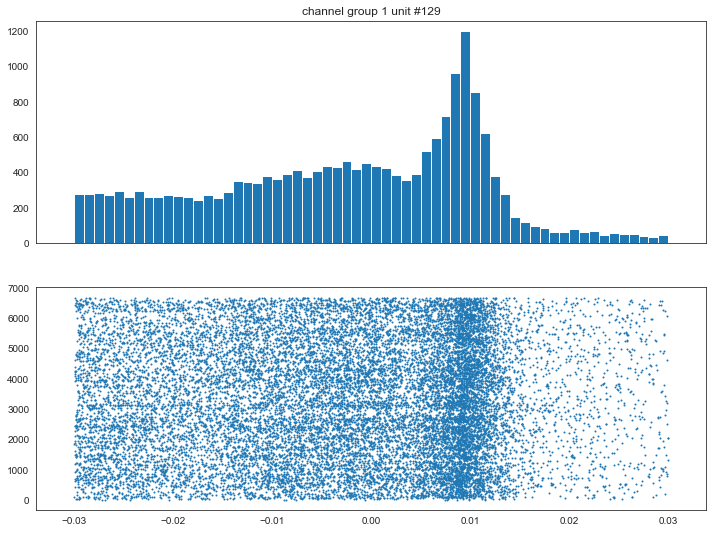

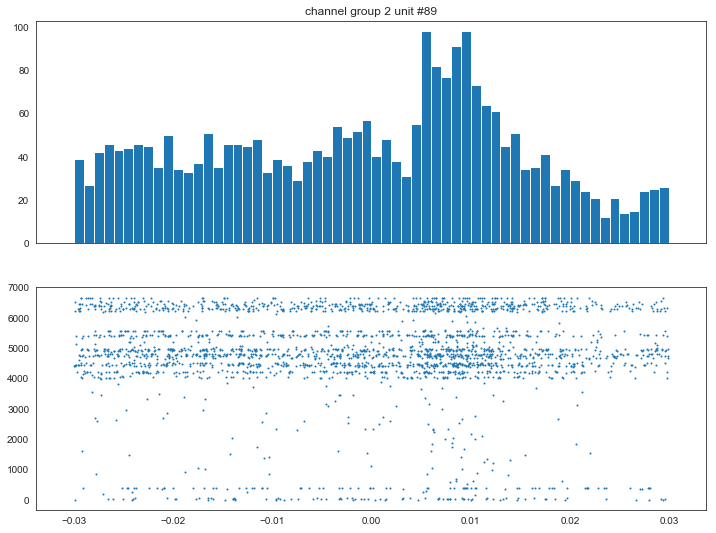

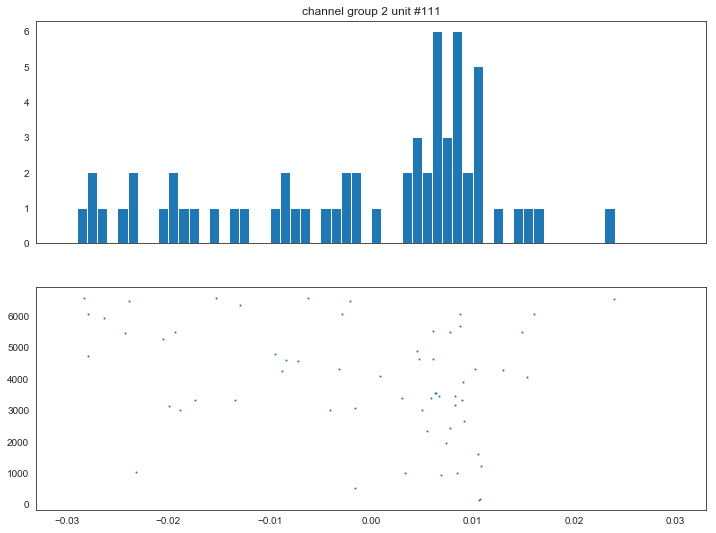

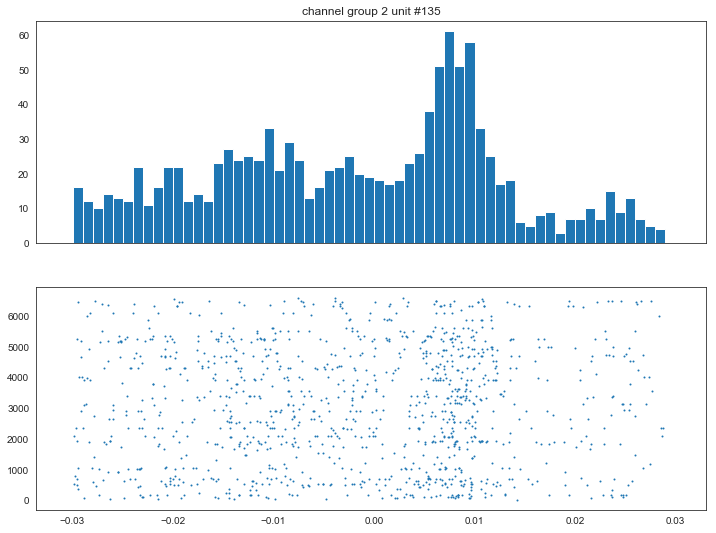

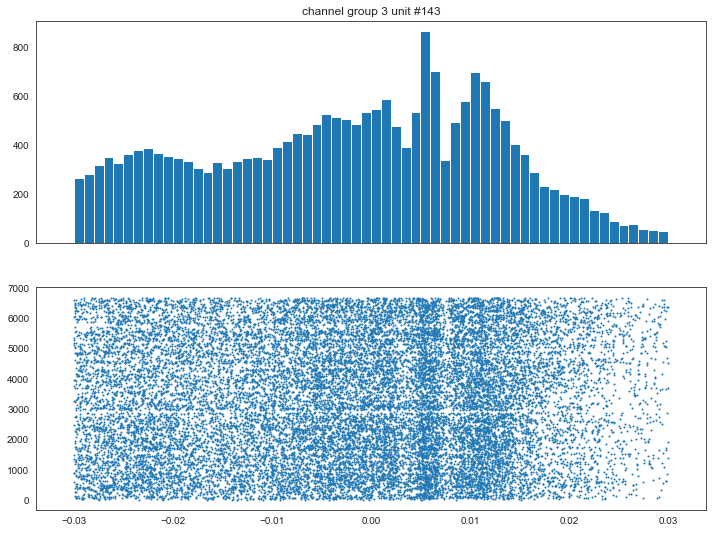

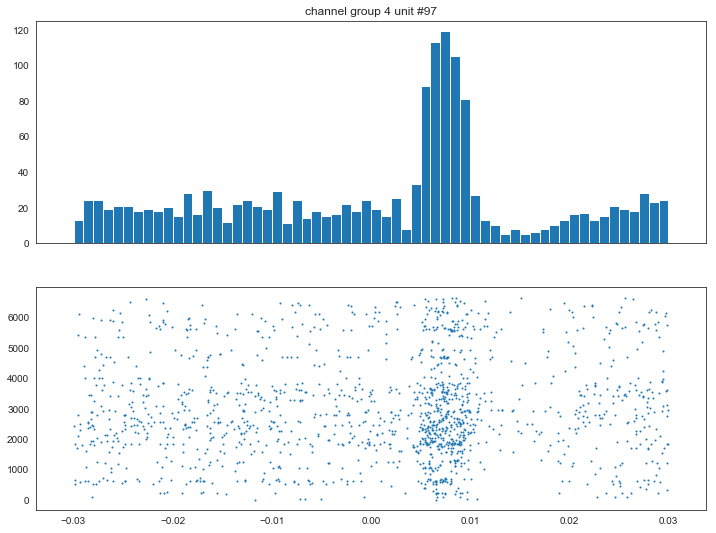

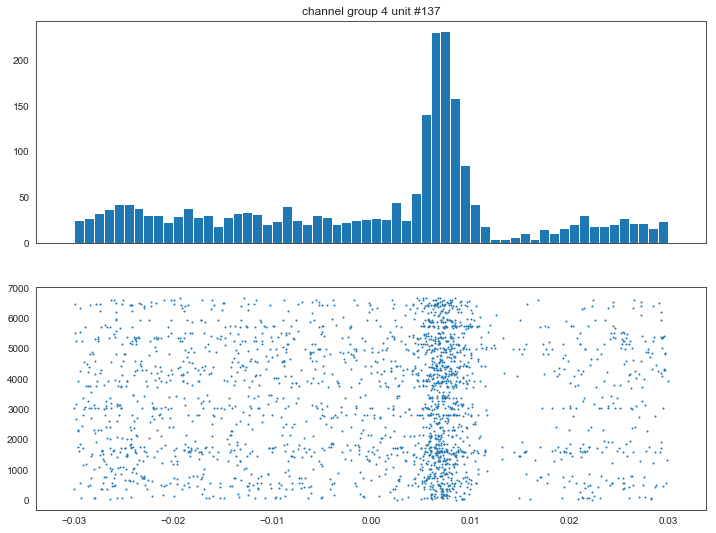

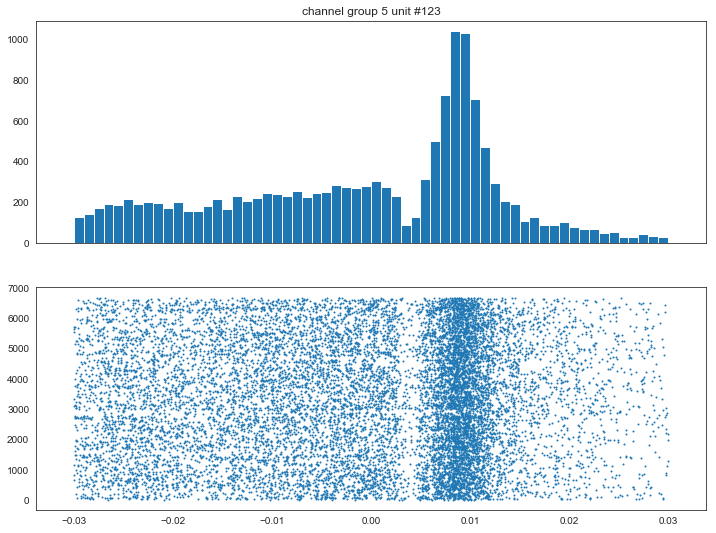

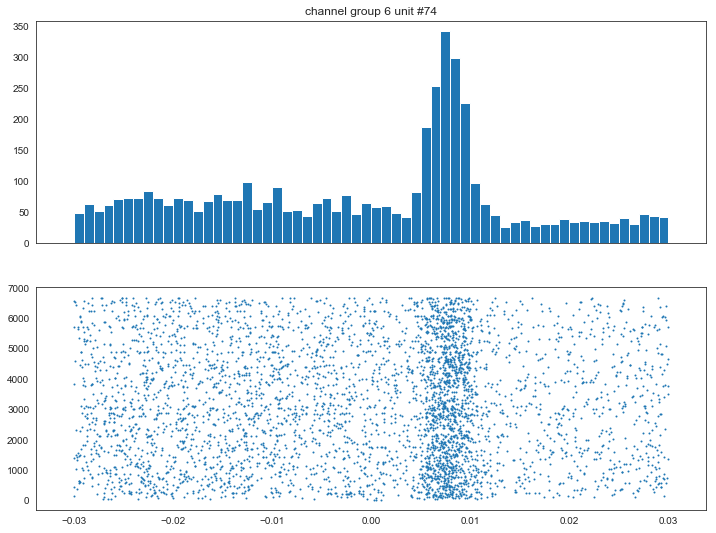

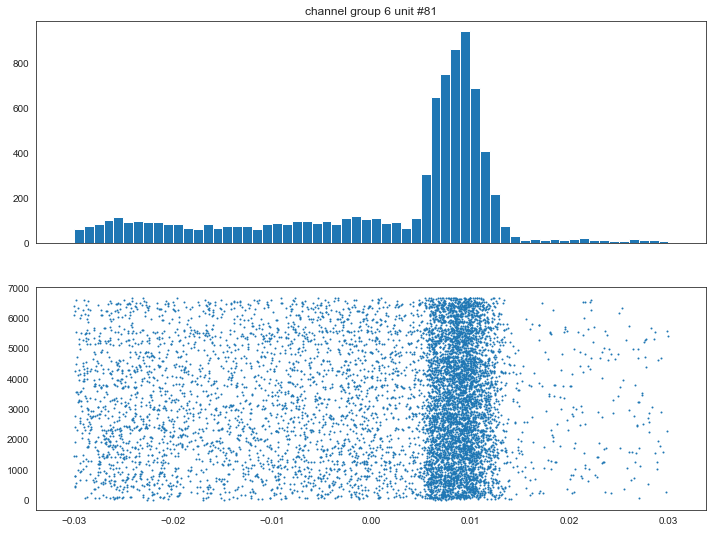

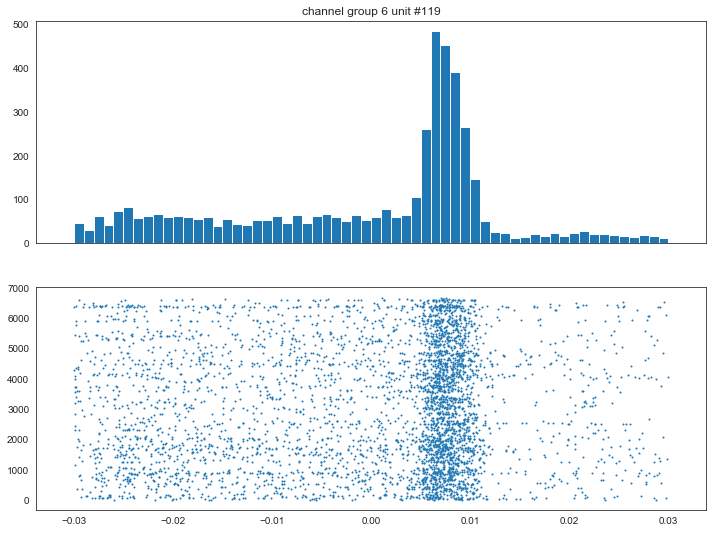

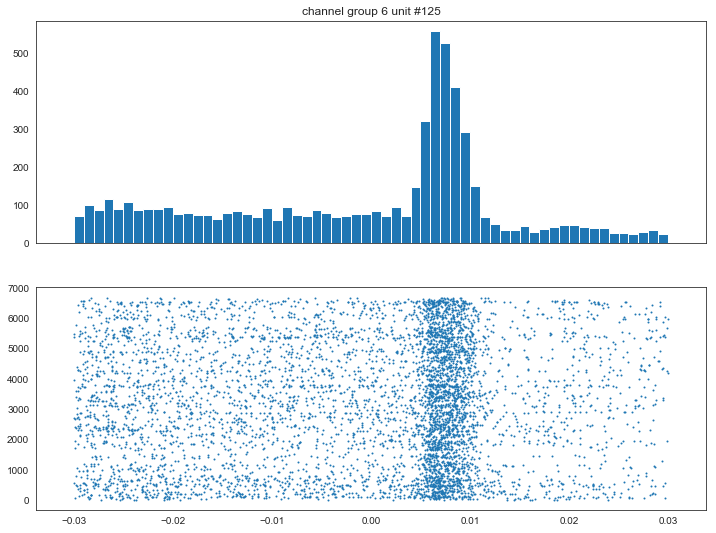

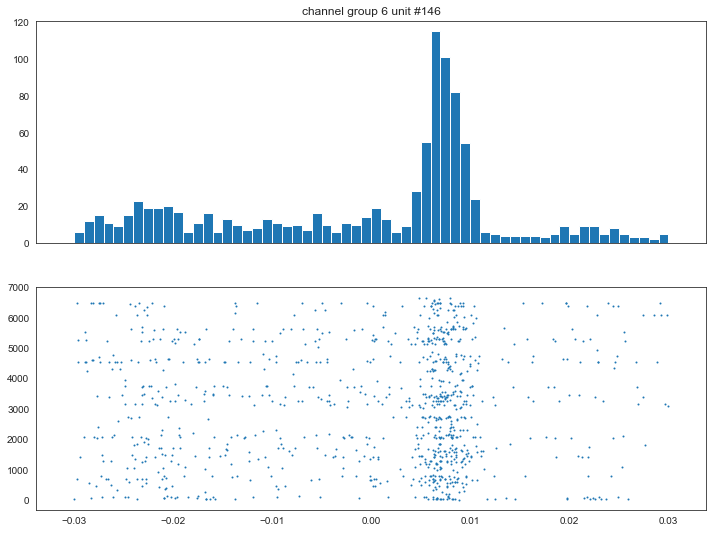

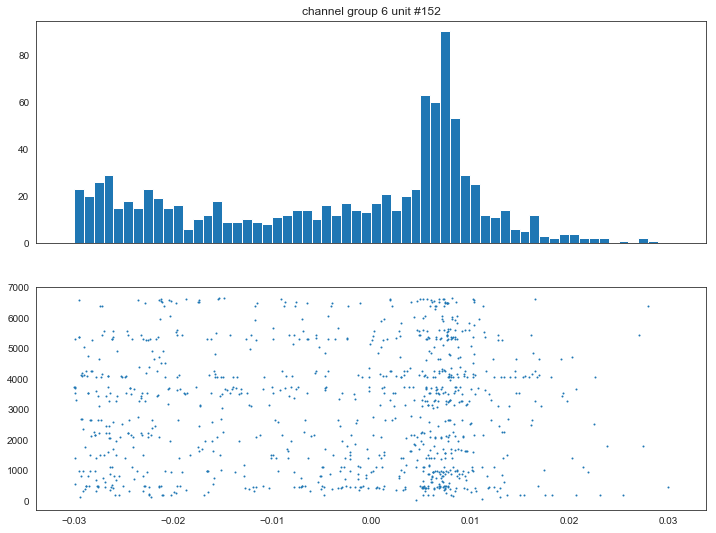

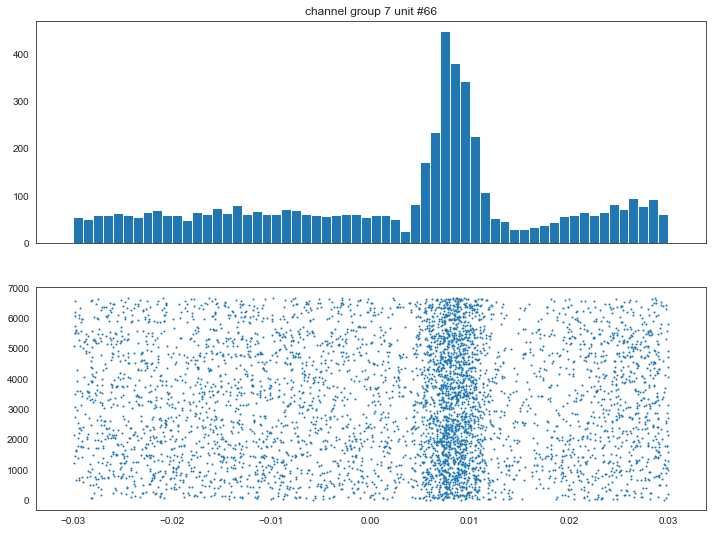

In [8]:
if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]

for channel_id in channel_ids:
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
    spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:
        if t_start is not None and t_stop is not None:
            spike_mask = (spike_times < t_stop) & (spike_times > t_start)
            spike_times = spike_times[spike_mask]

        psth(spike_times, epochs[0].times.magnitude, -0.03, 0.03, 0.001)


In [10]:
def get_unit(channel_group, unit):
    unit = f'unit #{unit}'
    spike_trains = dp.load_spiketrains(data_path, channel_group, load_waveforms=False)
    u = [s for s in spike_trains if s.annotations['name']==unit]
    if len(u) == 1:
        return u[0]

In [290]:
# unit = get_unit(5, 123)
unit = get_unit(6, 125)
# unit = get_unit(3, 143)

In [73]:
from optogenetics.stimulus_associated_latency import generate_salt_trials, salt

In [74]:
baseline_trials, test_trials = generate_salt_trials(unit, epochs[0])

In [75]:
l,p,i = salt(baseline_trials, test_trials, 0.001, 0.001, 0, 0.03, 0, 0.03)

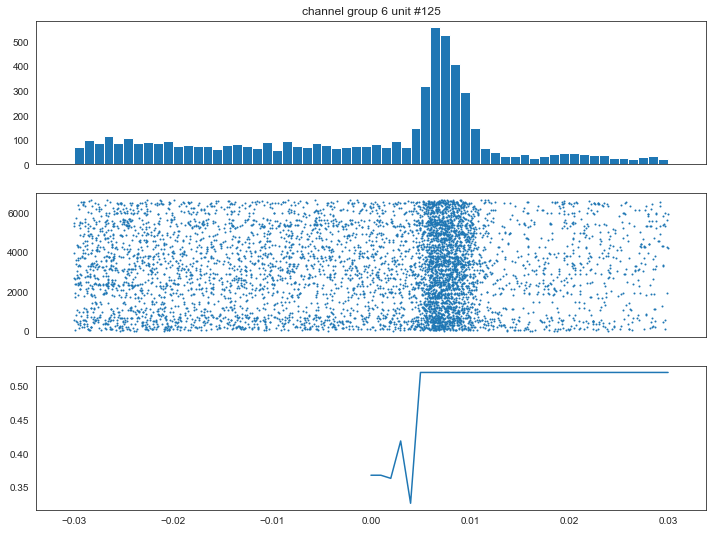

In [76]:
fig, axs = plt.subplots(3, 1, sharex=True)
psth(unit, epochs[0].times.magnitude, -0.03, 0.03, 0.001, axs=axs[:2])
axs[2].plot(l, p)

In [77]:
from scipy.signal import find_peaks

In [79]:
l[p==min(p[find_peaks(-p)[0]])]

array([0.004])

In [80]:
min(p)

0.3264367816091954

In [291]:
stim_times = np.array(epochs[0])
spike_times = np.array(unit)

In [218]:
from elephant.spike_train_surrogates import dither_spikes, dither_spike_train, randomise_spikes

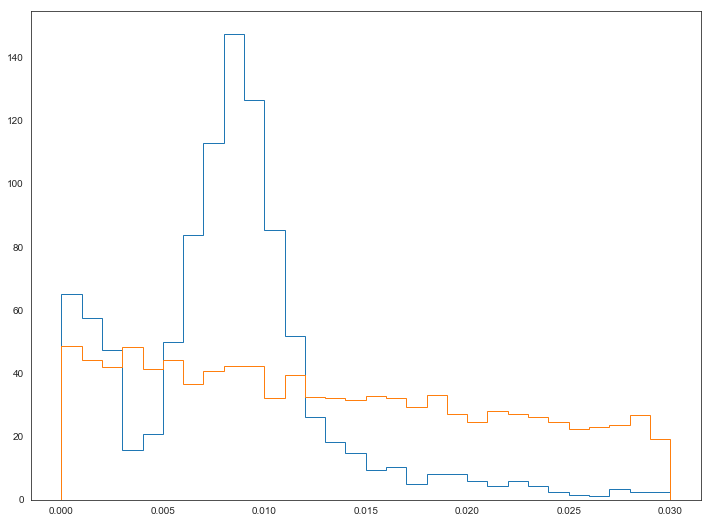

In [221]:
idxs = np.searchsorted(spike_times, stim_times, side='right')
bins = np.arange(0, 0.031, 0.001)
true_hist, _, _ = plt.hist(spike_times[idxs] - stim_times, bins=bins, histtype='step', density=True);

null_spikes = randomise_spikes(unit, 1)[0]
idxs = np.searchsorted(np.array(null_spikes), stim_times, side='right')
bins = np.arange(0, 0.031, 0.001)
plt.hist(np.array(null_spikes)[idxs] - stim_times, bins=bins, histtype='step', density=True);

KeyError: 'group_id'

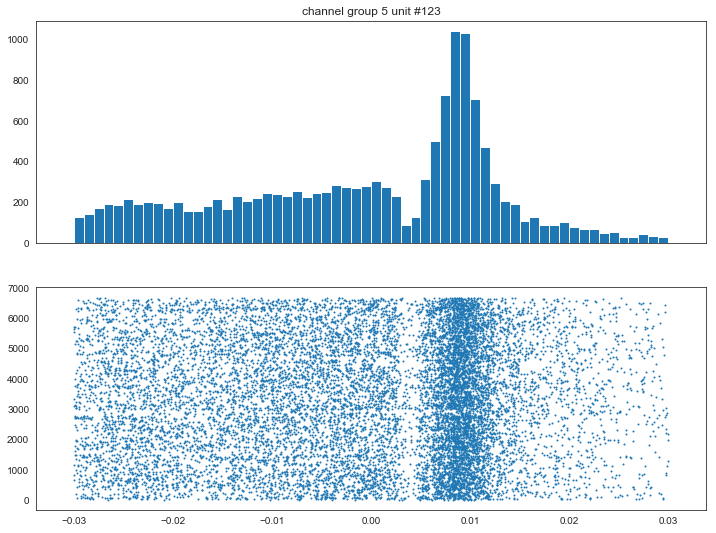

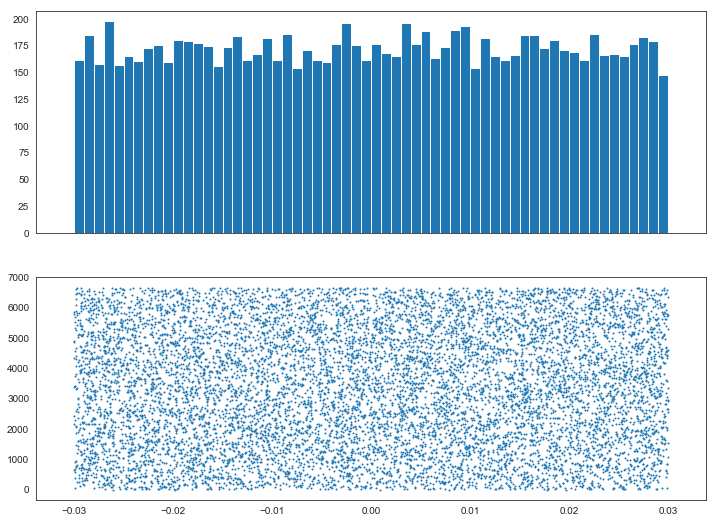

In [222]:
psth(unit, epochs[0].times.magnitude, -0.03, 0.03, 0.001)
psth(null_spikes, epochs[0].times.magnitude, -0.03, 0.03, 0.001)

In [224]:
null_spikes = randomise_spikes(unit, 1000)
bins = np.arange(0, 0.031, 0.001)
null_counts = []
for null_spike in null_spikes:
    null_spike = np.array(null_spike)
    idxs = np.searchsorted(null_spike, stim_times, side='right')
    hist, _ = np.histogram(null_spike[idxs] - stim_times, bins=bins, density=True);
    null_counts.append(hist)

In [225]:
null_counts = np.array(null_counts)

In [226]:
ps = []
for true, col in zip(true_hist, null_counts.T):
    p = sum(col > true) / len(col)
    ps.append(p)

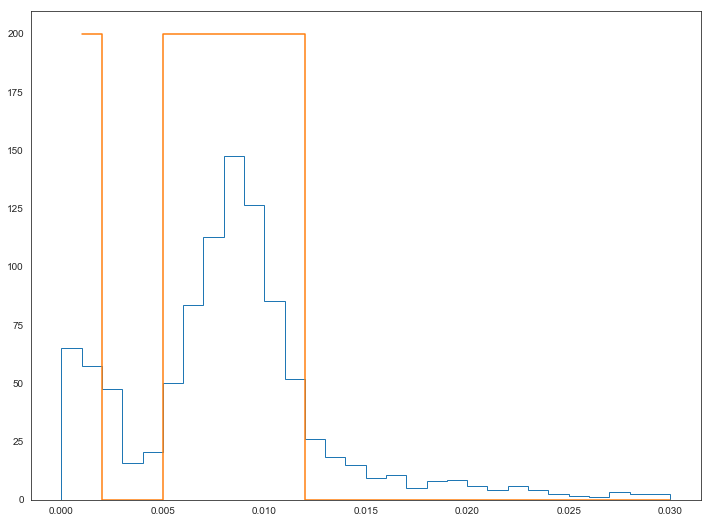

In [227]:
idxs = np.searchsorted(spike_times, stim_times, side='right')
bins = np.arange(0, 0.031, 0.001)
plt.hist(spike_times[idxs] - stim_times, bins=bins, histtype='step', density=True)
plt.step(bins[1:], (np.array(ps) < 0.01) * 200)

In [230]:
p_ = [t > s for t, s in zip(true_hist, np.percentile(null_counts, 99, 0))] 

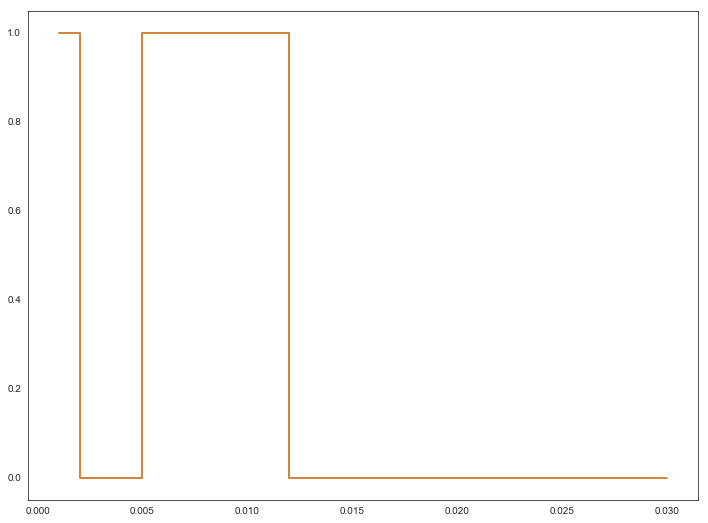

In [231]:
plt.step(bins[1:], np.array(ps) < 0.01)
plt.step(bins[1:], p_)

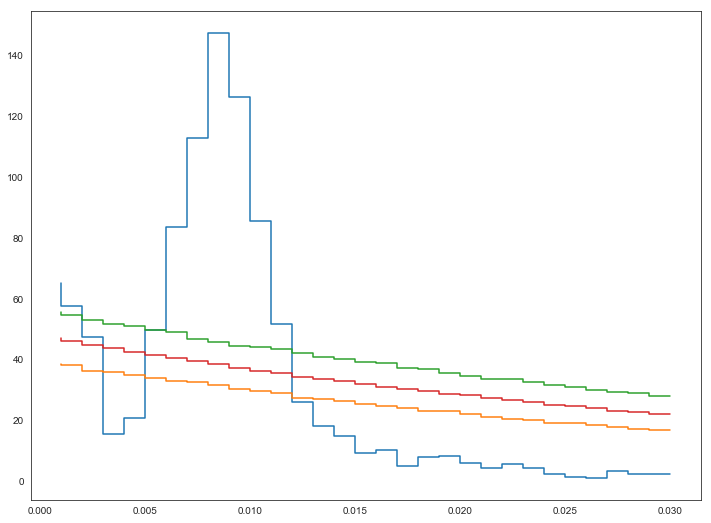

In [232]:
plt.step(bins[1:], true_hist)
plt.step(bins[1:], np.percentile(null_counts, 1, 0))
plt.step(bins[1:], np.percentile(null_counts, 99, 0))
plt.step(bins[1:], np.percentile(null_counts, 50, 0))
# plt.step(bins[1:], null_counts.mean(0) + null_counts.std(0), 'k')
# plt.step(bins[1:], null_counts.mean(0) - null_counts.std(0), 'k')

In [238]:
ps

[0.0,
 0.0,
 0.213,
 1.0,
 1.0,
 0.009,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [233]:
from optogenetics.stimulus_associated_latency import stimulus_response_latency

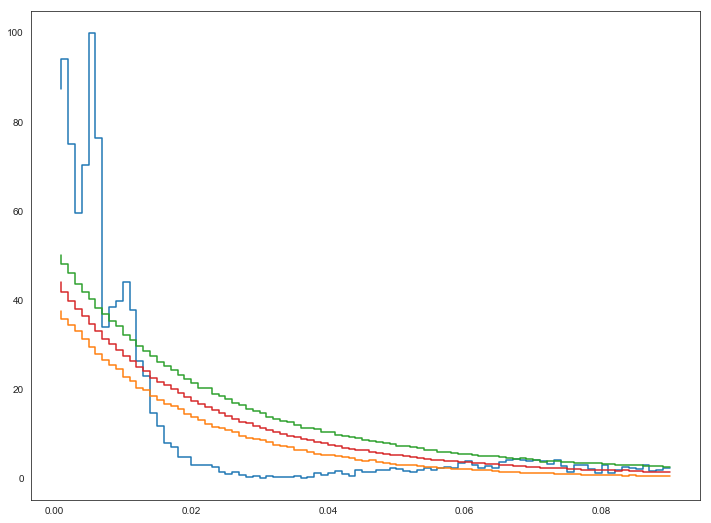

In [321]:
# unit = get_unit(5, 123)
# unit = get_unit(6, 125)
unit = get_unit(3, 143)

time, pe, pi = stimulus_response_latency(unit, epochs[0], 0.09, 0.001)

In [304]:
np.min(time[pe < 0.001])

0.0

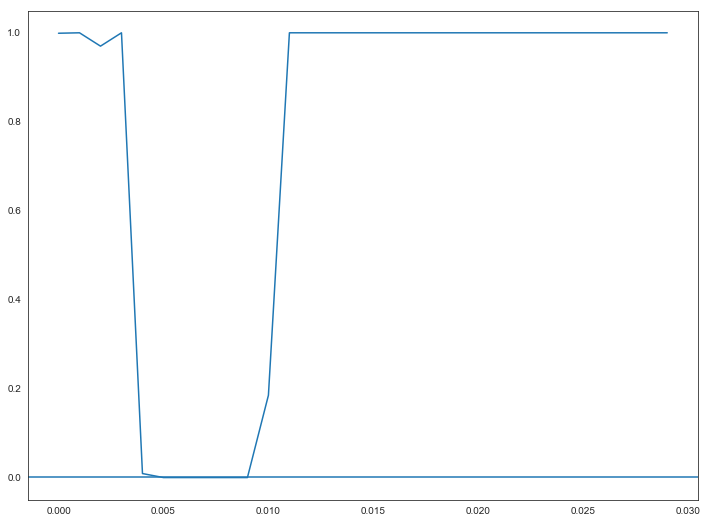

In [294]:
plt.plot(time, pe)
plt.axhline(0.001)

In [297]:
np.min(time[pi < 0.001])

0.001

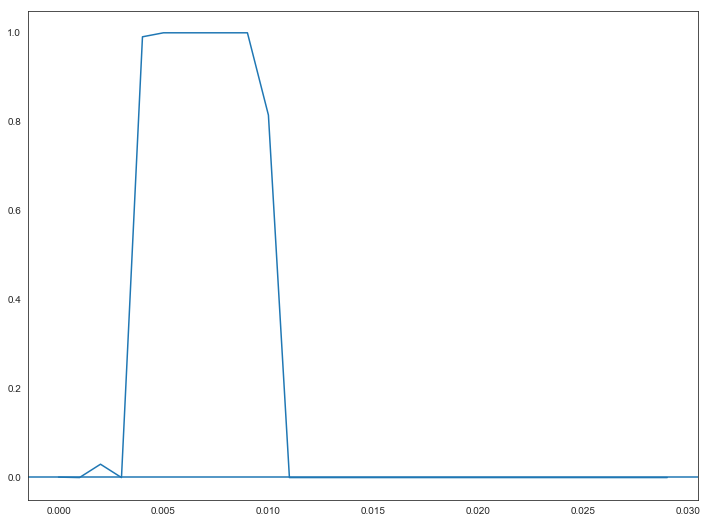

In [298]:
plt.plot(time, pi)
plt.axhline(0.001)